In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sc= SparkContext()
sqlContext = SQLContext(sc)

house_df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('boston.csv')
house_df.take(1)

[Row(ID=1, crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.538, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, black=396.9, lstat=4.98, medv=24.0)]

In [3]:
house_df.cache()
house_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- black: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



In [4]:
house_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
ID,333,250.95195195195194,147.8594378018597,1,506
crim,333,3.3603414714714708,7.352271836781104,0.00632,73.5341
zn,333,10.68918918918919,22.674761796618217,0.0,100.0
indus,333,11.29348348348346,6.998123104477312,0.74,27.74
chas,333,0.06006006006006006,0.2379556428164483,0,1
nox,333,0.557144144144145,0.11495450830289312,0.385,0.871
rm,333,6.265618618618616,0.7039515757334471,3.561,8.725
age,333,68.22642642642641,28.13334360562338,6.0,100.0
dis,333,3.7099336336336335,1.9811230514407001,1.1296,10.7103


In [5]:
import six
for i in house_df.columns:
    if not( isinstance(house_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to medv for ", i, house_df.stat.corr('medv',i))

Correlation to medv for  ID -0.22169418651611697
Correlation to medv for  crim -0.4074543235732598
Correlation to medv for  zn 0.34484197569664277
Correlation to medv for  indus -0.47393197065920345
Correlation to medv for  chas 0.20438998859918733
Correlation to medv for  nox -0.4130541519920783
Correlation to medv for  rm 0.6895980892872156
Correlation to medv for  age -0.35888827406190227
Correlation to medv for  dis 0.24942226829396397
Correlation to medv for  rad -0.3522508242456341
Correlation to medv for  tax -0.44807769440070433
Correlation to medv for  ptratio -0.48137595552491735
Correlation to medv for  black 0.33665955532155767
Correlation to medv for  lstat -0.7386000348786346
Correlation to medv for  medv 1.0


In [6]:
house_df.dtypes

[('ID', 'int'),
 ('crim', 'double'),
 ('zn', 'double'),
 ('indus', 'double'),
 ('chas', 'int'),
 ('nox', 'double'),
 ('rm', 'double'),
 ('age', 'double'),
 ('dis', 'double'),
 ('rad', 'int'),
 ('tax', 'int'),
 ('ptratio', 'double'),
 ('black', 'double'),
 ('lstat', 'double'),
 ('medv', 'double')]

/home/zhb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


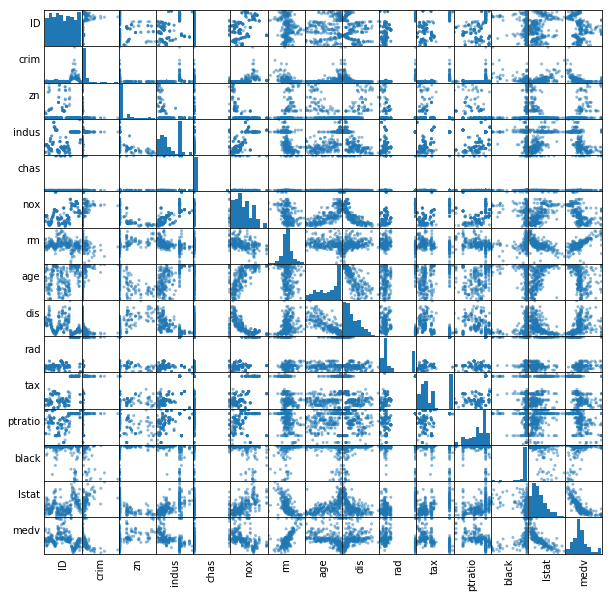

In [7]:
import pandas as pd
%matplotlib inline

numeric_features = [t[0] for t in house_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = house_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [11]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat'], outputCol = 'features')
vhouse_df = vectorAssembler.transform(house_df)
vhouse_df.take(1)

[Row(ID=1, crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.538, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, black=396.9, lstat=4.98, medv=24.0, features=DenseVector([0.0063, 18.0, 2.31, 0.0, 0.538, 6.575, 65.2, 4.09, 1.0, 296.0, 15.3, 396.9, 4.98]))]

In [12]:
vhouse_df = vhouse_df.select(['features', 'medv'])
vhouse_df.show(3)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.03237,0.0,2.18...|33.4|
+--------------------+----+
only showing top 3 rows



In [13]:
splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

### Linear Regression

In [14]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol='medv', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.0100142858942,0.0,0.449336208355,-3.8444755913,4.46905415233,0.0,-0.555567209594,0.0223970585854,0.0,-0.726175036639,0.0128680428076,-0.524945941977]
Intercept: 13.96924008410191


#### Summarize the model over the training set and print out some metrics

In [15]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 4.878160
r2: 0.711443


RMSE measures the differences between predicted values by the model and the actual values. However, RMSE alone is meaningless until we compare with the actual "MV" value, such as mean, min and max. After such comparison, our RMSE looks pretty good.

In [16]:
train_df.describe().show()

+-------+------------------+
|summary|              medv|
+-------+------------------+
|  count|               231|
|   mean|22.463203463203463|
| stddev| 9.100864084498223|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+



R squared at 0.74 indicates that in our model, approximate 74% of the variability in "MV" can be explained using the model. This is not bad.

In [17]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","medv","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="medv",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|30.820062349590614|32.2|[0.00906,90.0,2.9...|
|27.474522730118025|22.0|[0.01096,55.0,2.2...|
| 32.03513851873939|32.7|[0.01301,35.0,1.5...|
| 17.47430623031802|18.9|[0.0136,75.0,4.0,...|
|30.328885317596786|29.1|[0.01439,60.0,2.9...|
+------------------+----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.659351


In [18]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 5.42683


In [19]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 11
objectiveHistory: [0.5000000000000004, 0.43364974562945047, 0.24521364573645268, 0.2210868249037334, 0.1906990863825304, 0.18340387813242237, 0.18221828585388908, 0.18117469654985077, 0.1801492642504786, 0.17989939871191096, 0.17977534119020055]
+-------------------+
|          residuals|
+-------------------+
| -6.597944923683819|
|  4.830863748460317|
|0.24426381069794445|
| -3.245376651496347|
| 1.5626081622425474|
|-3.2518033354695035|
|  6.436226510507581|
|-0.3969895256128204|
|   10.6895159670351|
| -1.526216840555037|
|-10.177185289395702|
| -4.169038398980462|
|  1.650980636162675|
|0.11188048217879754|
| 1.5086679480914036|
|-1.8673398019169483|
|-3.6915885285015477|
|-2.0160970198212667|
| 10.457918759184146|
|-5.6160291049128155|
+-------------------+
only showing top 20 rows



In [20]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","medv","features").show()

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|30.820062349590614|32.2|[0.00906,90.0,2.9...|
|27.474522730118025|22.0|[0.01096,55.0,2.2...|
| 32.03513851873939|32.7|[0.01301,35.0,1.5...|
| 17.47430623031802|18.9|[0.0136,75.0,4.0,...|
|30.328885317596786|29.1|[0.01439,60.0,2.9...|
| 39.49418600615698|50.0|[0.01501,90.0,1.2...|
|31.078115342770296|31.1|[0.02187,60.0,2.9...|
| 25.53061860275952|21.6|[0.02731,0.0,7.07...|
|26.899724594994645|25.0|[0.02875,28.0,15....|
|30.137444337624288|33.4|[0.03237,0.0,2.18...|
| 32.29448841898387|34.9|[0.03359,75.0,2.9...|
|20.718091856259395|19.5|[0.03427,0.0,5.19...|
| 28.73149846795964|23.5|[0.03584,80.0,3.3...|
|  32.6231013556092|35.4|[0.03705,20.0,3.3...|
|24.043287792429023|20.5|[0.04337,21.0,5.6...|
| 23.55961533252789|19.4|[0.04379,80.0,3.3...|
|26.755204848055435|23.9|[0.04462,25.0,4.8...|
|22.959645316929127|20.6|[0.04527,0.0,11.9...|
| 21.64258857

### Decision tree regression

In [22]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'medv')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(
    labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 6.66377


### Feature Importance

In [23]:
train_df.take(1)

[Row(features=DenseVector([0.0063, 18.0, 2.31, 0.0, 0.538, 6.575, 65.2, 4.09, 1.0, 296.0, 15.3, 396.9, 4.98]), medv=24.0)]

In [24]:
dt_model.featureImportances

SparseVector(13, {0: 0.0785, 3: 0.0068, 4: 0.0053, 5: 0.6249, 6: 0.0083, 8: 0.0118, 10: 0.0065, 11: 0.0064, 12: 0.2515})

In [25]:
house_df.take(1)

[Row(ID=1, crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.538, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, black=396.9, lstat=4.98, medv=24.0)]

The number of rooms is the most important feature to predict the house price.

### Gradient-boosted tree regression

In [26]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'medv', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'medv', 'features').show(5)

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|27.716662884959216|32.2|[0.00906,90.0,2.9...|
|20.065231268599238|22.0|[0.01096,55.0,2.2...|
| 27.44805875695185|32.7|[0.01301,35.0,1.5...|
|15.577047630174658|18.9|[0.0136,75.0,4.0,...|
|27.943265489968198|29.1|[0.01439,60.0,2.9...|
+------------------+----+--------------------+
only showing top 5 rows



In [27]:
gbt_evaluator = RegressionEvaluator(
    labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 6.37782
